In [14]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
using HePPCAT
using Statistics
using Measures
#using PGFPlotsX
# pgfplotsx()
# #pyplot()
# Plots.scalefontsizes()
# Plots.scalefontsizes(0.75)
include("../alpcahFamily.jl")
include("../helperFunctions.jl")

heppcatWrapper_known (generic function with 1 method)

In [2]:
# All matrices have 1020 genes (rows) and 5000 cell samples (columns)
# Split evenly between subspaces and train/test data
#Y2train = load("mouse.jld", "train")
#Y2test = load("mouse.jld", "test")
# Ytest = load("human.jld", "test")
# Ytrain = load("human.jld", "train");
# dataSize = size(Ytrain)[2] # both test and train are the same

In [3]:
Ytest = load("david/original_data.jld", "test")
Ytrain = load("david/original_data.jld", "train");
dataSize = size(Ytrain)[2] # both test and train are the same

2500

In [4]:
using FlipPA
flippa(Ytrain[:,1:100]; quantile=0.95, trials=10, comparison=FlipPA.Pairwise())

5

In [6]:
k = 5; ### the rank of the experiment

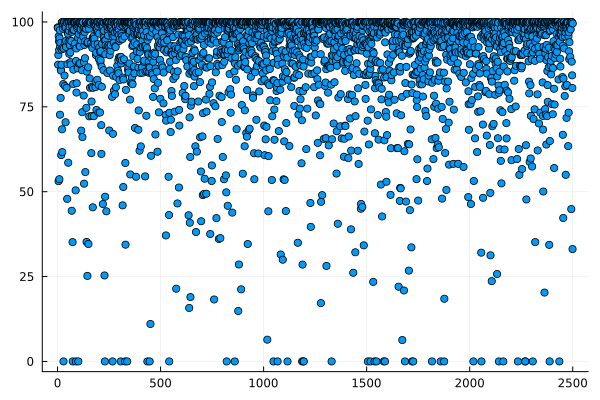

In [7]:
Utry = LR_ALPCAH(Ytrain, k);
v = grouplessVarianceUpdate(Ytrain, Utry*(Utry'*Ytrain))
scatter(v, label="")

In [27]:
pts = (v .< 50) .& (v .> 1)
sum((v .< 50) .& (v .> 1))

89

In [28]:
Utrue = PCA(Ytrain[:,pts],k);

In [31]:
niters = 100;
splitSize = round(Int, 1000)
num_trials = 10;

num_methods = 4
errors = zeros(num_methods,num_trials)
#train_errors = zeros(num_methods,num_trials)
#errors_subspaces = zeros(num_methods-1,num_trials)

p = Progress(num_trials; dt=1)
#Threads.@threads for iter=1:num_trials
for iter=1:num_trials
    trainShuffle = shuffle(1:dataSize)[1:splitSize]
    testShuffle = shuffle(1:dataSize)[1:splitSize]

    Ymat_train = Ytrain[:,trainShuffle]
    Ymat_test = Ytest[:,testShuffle]

    ### Homoscedastic PPCA both groups
    U_PCA = PCA(Ymat_test, k)

    #HEPPCAT UNGROUPED
    Ylist_test = []
    for t=1:splitSize
        push!(Ylist_test, Ymat_test[:,t])
    end
    Mheppcat = heppcat(Ylist_test,k,niters; varfloor=1e-9)

    # LR-ALPCAH
    U_ALPCAH_LR = LR_ALPCAH(Ymat_test, k; alpcahIter=niters)

    # ALPCAH
    U_ALPCAH = ALPCAH(Ymat_test, k, 10; μ=10, ρ=1.01, alpcahIter=5)

    # errors = []
    subspaces = [U_PCA, Mheppcat.U, U_ALPCAH_LR, U_ALPCAH]
    for (i,U) in enumerate(subspaces)
        errors[i,iter] = affinityError(Utry,U) #norm(Ymat_test - U*(U'*Ymat_test)) / norm(Ymat_test)
        #train_errors[i,iter] = norm(Ymat_train - U*(U'*Ymat_train)) / norm(Ymat_train)
    end

    # subspaces = [Mheppcat.U, U_ALPCAH_LR, U_ALPCAH]
    # for (i,U) in enumerate(subspaces)
    #     errors_subspaces[i,iter] = norm(U_PCA*U_PCA' - U*U')/norm(U_PCA*U_PCA')
    # end
    next!(p)
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:07:02


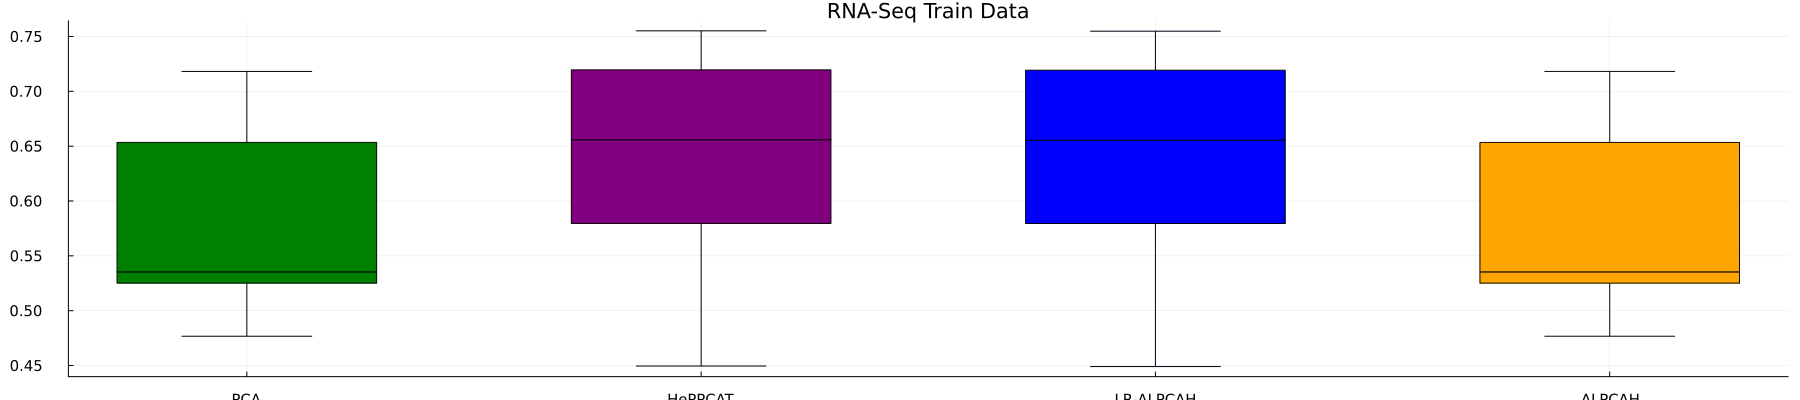

In [32]:
#pgfplotsx()
boxplots = []
titles = ["RNA-Seq Train Data", "RNA-Seq Test Data"]
ylabels = ["NRMSE", "NRMSE"]
#errors = [train_errors, test_errors];
for j=1:1
    p = plot(size=(500,300))
    p = boxplot(["PCA" "HePPCAT" "LR-ALPCAH" "ALPCAH"], errors', leg = false,title=titles[j],color=[:green :purple :blue :orange],
        ylabel=ylabels[j], yticks = :native)
#     p = ylims!((0,0.4))
    push!(boxplots,p)  
end

plot_boxes = plot(boxplots...,layout=(1,2),size=(1800,400),left_margin = 0mm,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))
#savefig("train_results.svg")